In [1]:
import time
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import circmean

import sqlite3
con = sqlite3.connect('../summer')
cur = con.cursor()

In [2]:
students = ['\'Alonzo\'','\'Dax\'','\'Emily\'','\'Isabelle\'','\'Jake\'','\'Philip\'','\'Rishab\'','\'Sam\'',
            '\'justin\'','\'Alex\'','\'Jordan\'']
recordings_train = ['\'week1_3\'', '\'week2_3\'', '\'week3_3\'', '\'week4_3\'', '\'week5_3\'', '\'week6_3\'']
recordings_test = ['\'week7_3\'', '\'week8_3\'']

all_weeks_train = pd.read_sql_query("""SELECT PlayerName, RecordingName,
    HeadPos_x, HeadPos_y, HeadPos_z, 
    LeftHandPos_x, LeftHandPos_y, LeftHandPos_z,
    RightHandPos_x, RightHandPos_y, RightHandPos_z,
    HeadRot_w, HeadRot_x, HeadRot_y, HeadRot_z,
    LeftHandRot_w, LeftHandRot_x, LeftHandRot_y, LeftHandRot_z,
    RightHandRot_w, RightHandRot_x, RightHandRot_y, RightHandRot_z
    FROM PersonTime
    WHERE PlayerName IN ({})
    AND RecordingName IN ({})
    """.format(",".join(students), ",".join(recordings_train)), con)

all_weeks_test = pd.read_sql_query("""SELECT PlayerName, RecordingName,
    HeadPos_x, HeadPos_y, HeadPos_z, 
    LeftHandPos_x, LeftHandPos_y, LeftHandPos_z,
    RightHandPos_x, RightHandPos_y, RightHandPos_z,
    HeadRot_w, HeadRot_x, HeadRot_y, HeadRot_z,
    LeftHandRot_w, LeftHandRot_x, LeftHandRot_y, LeftHandRot_z,
    RightHandRot_w, RightHandRot_x, RightHandRot_y, RightHandRot_z
    FROM PersonTime
    WHERE PlayerName IN ({})
    AND RecordingName IN ({})
    """.format(",".join(students), ",".join(recordings_test)), con)

print(all_weeks_train.shape)
print(all_weeks_test.shape)

(3189974, 23)
(919446, 23)


In [3]:
translations = ['HeadPos_y', 'LeftHandPos_y', 'RightHandPos_y']

playernames_train = all_weeks_train['PlayerName'].unique()
recordingnames_train = all_weeks_train['RecordingName'].unique()

playerIdx = {
    'Alonzo': 0,
    'Dax': 1,
    'Emily': 2,
    'Isabelle': 3,
    'Jake': 4,
    'Philip': 5,
    'Rishab': 6,
    'Sam': 7,
    'justin': 8,
    'Alex': 9,
    'Jordan': 10
}

X_train = []
y_train = []

head_q0, head_q1, head_q2, head_q3 = all_weeks_train['HeadRot_w'], all_weeks_train['HeadRot_x'], all_weeks_train['HeadRot_y'], all_weeks_train['HeadRot_z'], 
lhand_q0, lhand_q1, lhand_q2, lhand_q3 = all_weeks_train['LeftHandRot_w'], all_weeks_train['LeftHandRot_x'], all_weeks_train['LeftHandRot_y'], all_weeks_train['LeftHandRot_z'], 
rhand_q0, rhand_q1, rhand_q2, rhand_q3 = all_weeks_train['RightHandRot_w'], all_weeks_train['RightHandRot_x'], all_weeks_train['RightHandRot_y'], all_weeks_train['RightHandRot_z'], 

all_weeks_train['head_alpha'] = np.arctan2(2*(head_q0*head_q3-head_q1*head_q2), 1-2*(head_q3**2+head_q1**2))
all_weeks_train['head_beta'] = np.arcsin(2*(-head_q0*head_q1-head_q2*head_q3))
all_weeks_train['head_gamma'] = np.arctan2(2*(head_q0*head_q2-head_q3*head_q1), 1-2*(head_q1**2+head_q2**2))

all_weeks_train['lhand_alpha'] = np.arctan2(2*(lhand_q0*lhand_q3-lhand_q1*lhand_q2), 1-2*(lhand_q3**2+lhand_q1**2))
all_weeks_train['lhand_beta'] = np.arcsin(2*(-lhand_q0*lhand_q1-lhand_q2*lhand_q3))
all_weeks_train['lhand_gamma'] = np.arctan2(2*(lhand_q0*lhand_q2-lhand_q3*lhand_q1), 1-2*(lhand_q1**2+lhand_q2**2))

all_weeks_train['rhand_alpha'] = np.arctan2(2*(rhand_q0*rhand_q3-rhand_q1*rhand_q2), 1-2*(rhand_q3**2+rhand_q1**2))
all_weeks_train['rhand_beta'] = np.arcsin(2*(-rhand_q0*rhand_q1-rhand_q2*rhand_q3))
all_weeks_train['rhand_gamma'] = np.arctan2(2*(rhand_q0*rhand_q2-rhand_q3*rhand_q1), 1-2*(rhand_q1**2+rhand_q2**2))

euler_angles = ['head_alpha', 'head_beta', 'head_gamma', 
                'lhand_alpha', 'lhand_beta', 'lhand_gamma', 
                'rhand_alpha', 'rhand_beta', 'rhand_gamma']

print('start time: ', time.strftime("%H:%M:%S", time.localtime()))

for recording_name in recordingnames_train:
    recording_df = all_weeks_train[all_weeks_train['RecordingName'] == recording_name]
    
    print(recording_name, 'start_time', time.strftime("%H:%M:%S", time.localtime()))
    for name in playernames_train:
        player_df = recording_df[recording_df['PlayerName'] == name]
        
        print(name, 'start time', time.strftime("%H:%M:%S", time.localtime()))
                    
        for i in range(0, player_df.shape[0], 30): # center by starting at 15
            features_1s, features_3s, features_10s, features_30s = [], [], [], [] # features should be length 4x84

            window_1s = None
            window_3s = None
            window_10s = None
            window_30s = None

            if i < player_df.shape[0] - 29:
                window_1s = player_df.iloc[i : i + 29] # update indices to be centered
            if i < player_df.shape[0] - 89:
                window_3s = player_df.iloc[i : i + 89]
            if i < player_df.shape[0] - 299:
                window_10s = player_df.iloc[i : i + 299]
            if i < player_df.shape[0] - 899:
                window_30s = player_df.iloc[i : i + 899]

            for column_name in translations:
                if window_1s is not None:
                    column = window_1s[column_name]
                    features_1s.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])
                if window_3s is not None:
                    column = window_3s[column_name]
                    features_3s.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])
                if window_10s is not None:
                    column = window_10s[column_name]
                    features_10s.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])
                if window_30s is not None:
                    column = window_30s[column_name]
                    features_30s.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])

            for column_name in euler_angles:
                if window_1s is not None:
                    column = window_1s[column_name]
                    features_1s.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])
                if window_3s is not None:
                    column = window_3s[column_name]
                    features_3s.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])
                if window_10s is not None:
                    column = window_10s[column_name]
                    features_10s.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])
                if window_30s is not None:
                    column = window_30s[column_name]
                    features_30s.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])
            
            if window_1s is not None:
                head_x_offset = window_1s['HeadPos_x'] - window_1s['HeadPos_x'].mean()
                head_z_offset = window_1s['HeadPos_z'] - window_1s['HeadPos_z'].mean()
                head_angle = -circmean(window_1s['head_gamma'])
                head_surging = head_z_offset * np.cos(head_angle) - head_x_offset * np.sin(head_angle)
                head_strafing = head_z_offset * np.sin(head_angle) + head_x_offset * np.cos(head_angle)
                
                features_1s.extend([head_surging.max(), head_surging.min(), head_surging.median(), head_surging.std()])
                features_1s.extend([head_strafing.max(), head_strafing.min(), head_strafing.median(), head_strafing.std()])
                
                lhand_x_offset = window_1s['LeftHandPos_x'] - window_1s['LeftHandPos_x'].mean()
                lhand_z_offset = window_1s['LeftHandPos_z'] - window_1s['LeftHandPos_z'].mean()
                lhand_angle = -circmean(window_1s['lhand_gamma'])
                lhand_surging = lhand_z_offset * np.cos(lhand_angle) - lhand_x_offset * np.sin(lhand_angle)
                lhand_strafing = lhand_z_offset * np.sin(lhand_angle) + lhand_x_offset * np.cos(lhand_angle)
                
                features_1s.extend([lhand_surging.max(), lhand_surging.min(), lhand_surging.median(), lhand_surging.std()])
                features_1s.extend([lhand_strafing.max(), lhand_strafing.min(), lhand_strafing.median(), lhand_strafing.std()])
                
                rhand_x_offset = window_1s['RightHandPos_x'] - window_1s['RightHandPos_x'].mean()
                rhand_z_offset = window_1s['RightHandPos_z'] - window_1s['RightHandPos_z'].mean()
                rhand_angle = -circmean(window_1s['rhand_gamma'])
                rhand_surging = rhand_z_offset * np.cos(rhand_angle) - rhand_x_offset * np.sin(rhand_angle)
                rhand_strafing = rhand_z_offset * np.sin(rhand_angle) + rhand_x_offset * np.cos(rhand_angle)
                
                features_1s.extend([rhand_surging.max(), rhand_surging.min(), rhand_surging.median(), rhand_surging.std()])
                features_1s.extend([rhand_strafing.max(), rhand_strafing.min(), rhand_strafing.median(), rhand_strafing.std()])
                
                X_train.append(features_1s)
                y_train.append(playerIdx[name])
                
            if window_3s is not None:
                head_x_offset = window_3s['HeadPos_x'] - window_3s['HeadPos_x'].mean()
                head_z_offset = window_3s['HeadPos_z'] - window_3s['HeadPos_z'].mean()
                head_angle = -circmean(window_3s['head_gamma'])
                head_surging = head_z_offset * np.cos(head_angle) - head_x_offset * np.sin(head_angle)
                head_strafing = head_z_offset * np.sin(head_angle) + head_x_offset * np.cos(head_angle)
                
                features_3s.extend([head_surging.max(), head_surging.min(), head_surging.median(), head_surging.std()])
                features_3s.extend([head_strafing.max(), head_strafing.min(), head_strafing.median(), head_strafing.std()])
                
                lhand_x_offset = window_3s['LeftHandPos_x'] - window_3s['LeftHandPos_x'].mean()
                lhand_z_offset = window_3s['LeftHandPos_z'] - window_3s['LeftHandPos_z'].mean()
                lhand_angle = -circmean(window_3s['lhand_gamma'])
                lhand_surging = lhand_z_offset * np.cos(lhand_angle) - lhand_x_offset * np.sin(lhand_angle)
                lhand_strafing = lhand_z_offset * np.sin(lhand_angle) + lhand_x_offset * np.cos(lhand_angle)
                
                features_3s.extend([lhand_surging.max(), lhand_surging.min(), lhand_surging.median(), lhand_surging.std()])
                features_3s.extend([lhand_strafing.max(), lhand_strafing.min(), lhand_strafing.median(), lhand_strafing.std()])
                
                rhand_x_offset = window_3s['RightHandPos_x'] - window_3s['RightHandPos_x'].mean()
                rhand_z_offset = window_3s['RightHandPos_z'] - window_3s['RightHandPos_z'].mean()
                rhand_angle = -circmean(window_3s['rhand_gamma'])
                rhand_surging = rhand_z_offset * np.cos(rhand_angle) - rhand_x_offset * np.sin(rhand_angle)
                rhand_strafing = rhand_z_offset * np.sin(rhand_angle) + rhand_x_offset * np.cos(rhand_angle)
                
                features_3s.extend([rhand_surging.max(), rhand_surging.min(), rhand_surging.median(), rhand_surging.std()])
                features_3s.extend([rhand_strafing.max(), rhand_strafing.min(), rhand_strafing.median(), rhand_strafing.std()])
                
                X_train.append(features_3s)
                y_train.append(playerIdx[name])
            if window_10s is not None:
                head_x_offset = window_10s['HeadPos_x'] - window_10s['HeadPos_x'].mean()
                head_z_offset = window_10s['HeadPos_z'] - window_10s['HeadPos_z'].mean()
                head_angle = -circmean(window_10s['head_gamma'])
                head_surging = head_z_offset * np.cos(head_angle) - head_x_offset * np.sin(head_angle)
                head_strafing = head_z_offset * np.sin(head_angle) + head_x_offset * np.cos(head_angle)
                
                features_10s.extend([head_surging.max(), head_surging.min(), head_surging.median(), head_surging.std()])
                features_10s.extend([head_strafing.max(), head_strafing.min(), head_strafing.median(), head_strafing.std()])
                
                lhand_x_offset = window_10s['LeftHandPos_x'] - window_10s['LeftHandPos_x'].mean()
                lhand_z_offset = window_10s['LeftHandPos_z'] - window_10s['LeftHandPos_z'].mean()
                lhand_angle = -circmean(window_10s['lhand_gamma'])
                lhand_surging = lhand_z_offset * np.cos(lhand_angle) - lhand_x_offset * np.sin(lhand_angle)
                lhand_strafing = lhand_z_offset * np.sin(lhand_angle) + lhand_x_offset * np.cos(lhand_angle)
                
                features_10s.extend([lhand_surging.max(), lhand_surging.min(), lhand_surging.median(), lhand_surging.std()])
                features_10s.extend([lhand_strafing.max(), lhand_strafing.min(), lhand_strafing.median(), lhand_strafing.std()])
                
                rhand_x_offset = window_10s['RightHandPos_x'] - window_10s['RightHandPos_x'].mean()
                rhand_z_offset = window_10s['RightHandPos_z'] - window_10s['RightHandPos_z'].mean()
                rhand_angle = -circmean(window_10s['rhand_gamma'])
                rhand_surging = rhand_z_offset * np.cos(rhand_angle) - rhand_x_offset * np.sin(rhand_angle)
                rhand_strafing = rhand_z_offset * np.sin(rhand_angle) + rhand_x_offset * np.cos(rhand_angle)
                
                features_10s.extend([rhand_surging.max(), rhand_surging.min(), rhand_surging.median(), rhand_surging.std()])
                features_10s.extend([rhand_strafing.max(), rhand_strafing.min(), rhand_strafing.median(), rhand_strafing.std()])
                
                X_train.append(features_10s)
                y_train.append(playerIdx[name])
                
            if window_30s is not None:
                head_x_offset = window_30s['HeadPos_x'] - window_30s['HeadPos_x'].mean()
                head_z_offset = window_30s['HeadPos_z'] - window_30s['HeadPos_z'].mean()
                head_angle = -circmean(window_30s['head_gamma'])
                head_surging = head_z_offset * np.cos(head_angle) - head_x_offset * np.sin(head_angle)
                head_strafing = head_z_offset * np.sin(head_angle) + head_x_offset * np.cos(head_angle)
                
                features_30s.extend([head_surging.max(), head_surging.min(), head_surging.median(), head_surging.std()])
                features_30s.extend([head_strafing.max(), head_strafing.min(), head_strafing.median(), head_strafing.std()])
                
                lhand_x_offset = window_30s['LeftHandPos_x'] - window_30s['LeftHandPos_x'].mean()
                lhand_z_offset = window_30s['LeftHandPos_z'] - window_30s['LeftHandPos_z'].mean()
                lhand_angle = -circmean(window_30s['lhand_gamma'])
                lhand_surging = lhand_z_offset * np.cos(lhand_angle) - lhand_x_offset * np.sin(lhand_angle)
                lhand_strafing = lhand_z_offset * np.sin(lhand_angle) + lhand_x_offset * np.cos(lhand_angle)
                
                features_30s.extend([lhand_surging.max(), lhand_surging.min(), lhand_surging.median(), lhand_surging.std()])
                features_30s.extend([lhand_strafing.max(), lhand_strafing.min(), lhand_strafing.median(), lhand_strafing.std()])
                
                rhand_x_offset = window_30s['RightHandPos_x'] - window_30s['RightHandPos_x'].mean()
                rhand_z_offset = window_30s['RightHandPos_z'] - window_30s['RightHandPos_z'].mean()
                rhand_angle = -circmean(window_30s['rhand_gamma'])
                rhand_surging = rhand_z_offset * np.cos(rhand_angle) - rhand_x_offset * np.sin(rhand_angle)
                rhand_strafing = rhand_z_offset * np.sin(rhand_angle) + rhand_x_offset * np.cos(rhand_angle)
                
                features_30s.extend([rhand_surging.max(), rhand_surging.min(), rhand_surging.median(), rhand_surging.std()])
                features_30s.extend([rhand_strafing.max(), rhand_strafing.min(), rhand_strafing.median(), rhand_strafing.std()])
                
                X_train.append(features_30s)
                y_train.append(playerIdx[name])
                
                
print('end time: ', time.strftime("%H:%M:%S", time.localtime()))

print(len(X_train))
print(len(X_train[0]))
print(len(y_train))

start time:  13:13:24
week1_3 start_time 13:13:25
Alonzo start time 13:13:25
Dax start time 13:14:52
Emily start time 13:16:19
Isabelle start time 13:17:26
Jake start time 13:18:31
Philip start time 13:19:49
Rishab start time 13:21:14
Sam start time 13:22:18
justin start time 13:23:24
Alex start time 13:24:44
Jordan start time 13:25:48
week2_3 start_time 13:26:53
Alonzo start time 13:26:53
Dax start time 13:27:54
Emily start time 13:28:55
Isabelle start time 13:29:50
Jake start time 13:30:49
Philip start time 13:31:50
Rishab start time 13:32:37
Sam start time 13:33:23
justin start time 13:34:16
Alex start time 13:35:19
Jordan start time 13:36:10
week3_3 start_time 13:36:54
Alonzo start time 13:36:54
Dax start time 13:38:21
Emily start time 13:39:57
Isabelle start time 13:41:16
Jake start time 13:41:16
Philip start time 13:42:42
Rishab start time 13:44:11
Sam start time 13:45:17
justin start time 13:46:39
Alex start time 13:48:04
Jordan start time 13:49:17
week4_3 start_time 13:50:22
Al

In [4]:
playernames_test = all_weeks_test['PlayerName'].unique()
recordingnames_test = all_weeks_test['RecordingName'].unique()

X_test = []
y_test = []

head_q0, head_q1, head_q2, head_q3 = all_weeks_test['HeadRot_w'], all_weeks_test['HeadRot_x'], all_weeks_test['HeadRot_y'], all_weeks_test['HeadRot_z'], 
lhand_q0, lhand_q1, lhand_q2, lhand_q3 = all_weeks_test['LeftHandRot_w'], all_weeks_test['LeftHandRot_x'], all_weeks_test['LeftHandRot_y'], all_weeks_test['LeftHandRot_z'], 
rhand_q0, rhand_q1, rhand_q2, rhand_q3 = all_weeks_test['RightHandRot_w'], all_weeks_test['RightHandRot_x'], all_weeks_test['RightHandRot_y'], all_weeks_test['RightHandRot_z'], 

all_weeks_test['head_alpha'] = np.arctan2(2*(head_q0*head_q3-head_q1*head_q2), 1-2*(head_q3**2+head_q1**2))
all_weeks_test['head_beta'] = np.arcsin(2*(-head_q0*head_q1-head_q2*head_q3))
all_weeks_test['head_gamma'] = np.arctan2(2*(head_q0*head_q2-head_q3*head_q1), 1-2*(head_q1**2+head_q2**2))

all_weeks_test['lhand_alpha'] = np.arctan2(2*(lhand_q0*lhand_q3-lhand_q1*lhand_q2), 1-2*(lhand_q3**2+lhand_q1**2))
all_weeks_test['lhand_beta'] = np.arcsin(2*(-lhand_q0*lhand_q1-lhand_q2*lhand_q3))
all_weeks_test['lhand_gamma'] = np.arctan2(2*(lhand_q0*lhand_q2-lhand_q3*lhand_q1), 1-2*(lhand_q1**2+lhand_q2**2))

all_weeks_test['rhand_alpha'] = np.arctan2(2*(rhand_q0*rhand_q3-rhand_q1*rhand_q2), 1-2*(rhand_q3**2+rhand_q1**2))
all_weeks_test['rhand_beta'] = np.arcsin(2*(-rhand_q0*rhand_q1-rhand_q2*rhand_q3))
all_weeks_test['rhand_gamma'] = np.arctan2(2*(rhand_q0*rhand_q2-rhand_q3*rhand_q1), 1-2*(rhand_q1**2+rhand_q2**2))

print('start time: ', time.strftime("%H:%M:%S", time.localtime()))

for name in playernames_test:
    player_df = all_weeks_test[all_weeks_test['PlayerName'] == name]
        
    print(name, 'start time', time.strftime("%H:%M:%S", time.localtime()))
    
    
    for recording_name in recordingnames_test:
        recording_df = player_df[player_df['RecordingName'] == recording_name]

        print(recording_name, 'start_time', time.strftime("%H:%M:%S", time.localtime()))

        for i in range(0, recording_df.shape[0], 30):
            features_1s, features_3s, features_10s, features_30s = [], [], [], []

            window_1s = None
            window_3s = None
            window_10s = None
            window_30s = None

            if i < recording_df.shape[0] - 29:
                window_1s = recording_df.iloc[i : i + 29]
            if i < recording_df.shape[0] - 89:
                window_3s = recording_df.iloc[i : i + 89]
            if i < recording_df.shape[0] - 299:
                window_10s = recording_df.iloc[i : i + 299]
            if i < recording_df.shape[0] - 899:
                window_30s = recording_df.iloc[i : i + 899]

            for column_name in translations:
                if window_1s is not None:
                    column = window_1s[column_name]
                    features_1s.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])
                if window_3s is not None:
                    column = window_3s[column_name]
                    features_3s.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])
                if window_10s is not None:
                    column = window_10s[column_name]
                    features_10s.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])
                if window_30s is not None:
                    column = window_30s[column_name]
                    features_30s.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])

            for column_name in euler_angles:
                if window_1s is not None:
                    column = window_1s[column_name]
                    features_1s.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])
                if window_3s is not None:
                    column = window_3s[column_name]
                    features_3s.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])
                if window_10s is not None:
                    column = window_10s[column_name]
                    features_10s.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])
                if window_30s is not None:
                    column = window_30s[column_name]
                    features_30s.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])
            
            
            if window_1s is not None:
                head_x_offset = window_1s['HeadPos_x'] - window_1s['HeadPos_x'].mean()
                head_z_offset = window_1s['HeadPos_z'] - window_1s['HeadPos_z'].mean()
                head_angle = -circmean(window_1s['head_gamma'])
                head_surging = head_z_offset * np.cos(head_angle) - head_x_offset * np.sin(head_angle)
                head_strafing = head_z_offset * np.sin(head_angle) + head_x_offset * np.cos(head_angle)
                
                features_1s.extend([head_surging.max(), head_surging.min(), head_surging.median(), head_surging.std()])
                features_1s.extend([head_strafing.max(), head_strafing.min(), head_strafing.median(), head_strafing.std()])
                
                lhand_x_offset = window_1s['LeftHandPos_x'] - window_1s['LeftHandPos_x'].mean()
                lhand_z_offset = window_1s['LeftHandPos_z'] - window_1s['LeftHandPos_z'].mean()
                lhand_angle = -circmean(window_1s['lhand_gamma'])
                lhand_surging = lhand_z_offset * np.cos(lhand_angle) - lhand_x_offset * np.sin(lhand_angle)
                lhand_strafing = lhand_z_offset * np.sin(lhand_angle) + lhand_x_offset * np.cos(lhand_angle)
                
                features_1s.extend([lhand_surging.max(), lhand_surging.min(), lhand_surging.median(), lhand_surging.std()])
                features_1s.extend([lhand_strafing.max(), lhand_strafing.min(), lhand_strafing.median(), lhand_strafing.std()])
                
                rhand_x_offset = window_1s['RightHandPos_x'] - window_1s['RightHandPos_x'].mean()
                rhand_z_offset = window_1s['RightHandPos_z'] - window_1s['RightHandPos_z'].mean()
                rhand_angle = -circmean(window_1s['rhand_gamma'])
                rhand_surging = rhand_z_offset * np.cos(rhand_angle) - rhand_x_offset * np.sin(rhand_angle)
                rhand_strafing = rhand_z_offset * np.sin(rhand_angle) + rhand_x_offset * np.cos(rhand_angle)
                
                features_1s.extend([rhand_surging.max(), rhand_surging.min(), rhand_surging.median(), rhand_surging.std()])
                features_1s.extend([rhand_strafing.max(), rhand_strafing.min(), rhand_strafing.median(), rhand_strafing.std()])
                
                X_test.append(features_1s)
                y_test.append(playerIdx[name])
                
            if window_3s is not None:
                head_x_offset = window_3s['HeadPos_x'] - window_3s['HeadPos_x'].mean()
                head_z_offset = window_3s['HeadPos_z'] - window_3s['HeadPos_z'].mean()
                head_angle = -circmean(window_3s['head_gamma'])
                head_surging = head_z_offset * np.cos(head_angle) - head_x_offset * np.sin(head_angle)
                head_strafing = head_z_offset * np.sin(head_angle) + head_x_offset * np.cos(head_angle)
                
                features_3s.extend([head_surging.max(), head_surging.min(), head_surging.median(), head_surging.std()])
                features_3s.extend([head_strafing.max(), head_strafing.min(), head_strafing.median(), head_strafing.std()])
                
                lhand_x_offset = window_3s['LeftHandPos_x'] - window_3s['LeftHandPos_x'].mean()
                lhand_z_offset = window_3s['LeftHandPos_z'] - window_3s['LeftHandPos_z'].mean()
                lhand_angle = -circmean(window_3s['lhand_gamma'])
                lhand_surging = lhand_z_offset * np.cos(lhand_angle) - lhand_x_offset * np.sin(lhand_angle)
                lhand_strafing = lhand_z_offset * np.sin(lhand_angle) + lhand_x_offset * np.cos(lhand_angle)
                
                features_3s.extend([lhand_surging.max(), lhand_surging.min(), lhand_surging.median(), lhand_surging.std()])
                features_3s.extend([lhand_strafing.max(), lhand_strafing.min(), lhand_strafing.median(), lhand_strafing.std()])
                
                rhand_x_offset = window_3s['RightHandPos_x'] - window_3s['RightHandPos_x'].mean()
                rhand_z_offset = window_3s['RightHandPos_z'] - window_3s['RightHandPos_z'].mean()
                rhand_angle = -circmean(window_3s['rhand_gamma'])
                rhand_surging = rhand_z_offset * np.cos(rhand_angle) - rhand_x_offset * np.sin(rhand_angle)
                rhand_strafing = rhand_z_offset * np.sin(rhand_angle) + rhand_x_offset * np.cos(rhand_angle)
                
                features_3s.extend([rhand_surging.max(), rhand_surging.min(), rhand_surging.median(), rhand_surging.std()])
                features_3s.extend([rhand_strafing.max(), rhand_strafing.min(), rhand_strafing.median(), rhand_strafing.std()])
                
                X_test.append(features_3s)
                y_test.append(playerIdx[name])
                
            if window_10s is not None:
                head_x_offset = window_10s['HeadPos_x'] - window_10s['HeadPos_x'].mean()
                head_z_offset = window_10s['HeadPos_z'] - window_10s['HeadPos_z'].mean()
                head_angle = -circmean(window_10s['head_gamma'])
                head_surging = head_z_offset * np.cos(head_angle) - head_x_offset * np.sin(head_angle)
                head_strafing = head_z_offset * np.sin(head_angle) + head_x_offset * np.cos(head_angle)
                
                features_10s.extend([head_surging.max(), head_surging.min(), head_surging.median(), head_surging.std()])
                features_10s.extend([head_strafing.max(), head_strafing.min(), head_strafing.median(), head_strafing.std()])
                
                lhand_x_offset = window_10s['LeftHandPos_x'] - window_10s['LeftHandPos_x'].mean()
                lhand_z_offset = window_10s['LeftHandPos_z'] - window_10s['LeftHandPos_z'].mean()
                lhand_angle = -circmean(window_10s['lhand_gamma'])
                lhand_surging = lhand_z_offset * np.cos(lhand_angle) - lhand_x_offset * np.sin(lhand_angle)
                lhand_strafing = lhand_z_offset * np.sin(lhand_angle) + lhand_x_offset * np.cos(lhand_angle)
                
                features_10s.extend([lhand_surging.max(), lhand_surging.min(), lhand_surging.median(), lhand_surging.std()])
                features_10s.extend([lhand_strafing.max(), lhand_strafing.min(), lhand_strafing.median(), lhand_strafing.std()])
                
                rhand_x_offset = window_10s['RightHandPos_x'] - window_10s['RightHandPos_x'].mean()
                rhand_z_offset = window_10s['RightHandPos_z'] - window_10s['RightHandPos_z'].mean()
                rhand_angle = -circmean(window_10s['rhand_gamma'])
                rhand_surging = rhand_z_offset * np.cos(rhand_angle) - rhand_x_offset * np.sin(rhand_angle)
                rhand_strafing = rhand_z_offset * np.sin(rhand_angle) + rhand_x_offset * np.cos(rhand_angle)
                
                features_10s.extend([rhand_surging.max(), rhand_surging.min(), rhand_surging.median(), rhand_surging.std()])
                features_10s.extend([rhand_strafing.max(), rhand_strafing.min(), rhand_strafing.median(), rhand_strafing.std()])
                
                X_test.append(features_10s)
                y_test.append(playerIdx[name])
                
            if window_30s is not None:
                head_x_offset = window_30s['HeadPos_x'] - window_30s['HeadPos_x'].mean()
                head_z_offset = window_30s['HeadPos_z'] - window_30s['HeadPos_z'].mean()
                head_angle = -circmean(window_30s['head_gamma'])
                head_surging = head_z_offset * np.cos(head_angle) - head_x_offset * np.sin(head_angle)
                head_strafing = head_z_offset * np.sin(head_angle) + head_x_offset * np.cos(head_angle)
                
                features_30s.extend([head_surging.max(), head_surging.min(), head_surging.median(), head_surging.std()])
                features_30s.extend([head_strafing.max(), head_strafing.min(), head_strafing.median(), head_strafing.std()])
                
                lhand_x_offset = window_30s['LeftHandPos_x'] - window_30s['LeftHandPos_x'].mean()
                lhand_z_offset = window_30s['LeftHandPos_z'] - window_30s['LeftHandPos_z'].mean()
                lhand_angle = -circmean(window_30s['lhand_gamma'])
                lhand_surging = lhand_z_offset * np.cos(lhand_angle) - lhand_x_offset * np.sin(lhand_angle)
                lhand_strafing = lhand_z_offset * np.sin(lhand_angle) + lhand_x_offset * np.cos(lhand_angle)
                
                features_30s.extend([lhand_surging.max(), lhand_surging.min(), lhand_surging.median(), lhand_surging.std()])
                features_30s.extend([lhand_strafing.max(), lhand_strafing.min(), lhand_strafing.median(), lhand_strafing.std()])
                
                rhand_x_offset = window_30s['RightHandPos_x'] - window_30s['RightHandPos_x'].mean()
                rhand_z_offset = window_30s['RightHandPos_z'] - window_30s['RightHandPos_z'].mean()
                rhand_angle = -circmean(window_30s['rhand_gamma'])
                rhand_surging = rhand_z_offset * np.cos(rhand_angle) - rhand_x_offset * np.sin(rhand_angle)
                rhand_strafing = rhand_z_offset * np.sin(rhand_angle) + rhand_x_offset * np.cos(rhand_angle)
                
                features_30s.extend([rhand_surging.max(), rhand_surging.min(), rhand_surging.median(), rhand_surging.std()])
                features_30s.extend([rhand_strafing.max(), rhand_strafing.min(), rhand_strafing.median(), rhand_strafing.std()])
                
                X_test.append(features_30s)
                y_test.append(playerIdx[name])
                
                
print('end time: ', time.strftime("%H:%M:%S", time.localtime()))

print(len(X_test))
print(len(X_test[0]))
print(len(y_test))

start time:  14:13:51
Alonzo start time 14:13:52
week7_3 start_time 14:13:52
week8_3 start_time 14:14:39
Jake start time 14:15:51
week7_3 start_time 14:15:51
week8_3 start_time 14:16:38
Jordan start time 14:17:51
week7_3 start_time 14:17:51
week8_3 start_time 14:18:36
justin start time 14:19:46
week7_3 start_time 14:19:46
week8_3 start_time 14:20:33
Alex start time 14:21:45
week7_3 start_time 14:21:45
week8_3 start_time 14:22:32
Isabelle start time 14:23:44
week7_3 start_time 14:23:44
week8_3 start_time 14:24:30
Emily start time 14:24:30
week7_3 start_time 14:24:30
week8_3 start_time 14:25:15
Philip start time 14:26:28
week7_3 start_time 14:26:28
week8_3 start_time 14:27:13
Dax start time 14:28:26
week7_3 start_time 14:28:26
week8_3 start_time 14:29:06
Rishab start time 14:30:20
week7_3 start_time 14:30:20
week8_3 start_time 14:30:22
end time:  14:31:26
121792
84
121792


In [5]:
scaler = StandardScaler()
X_train_fitted = scaler.fit_transform(X_train)
X_test_fitted = scaler.transform(X_test)

In [6]:
print('start time: ', time.strftime("%H:%M:%S", time.localtime()))
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
classifier.fit(X_train_fitted, y_train)
print('end time: ', time.strftime("%H:%M:%S", time.localtime()))

start time:  14:31:33
end time:  14:41:39


In [7]:
y_pred = classifier.predict(X_test_fitted)
print(accuracy_score(y_test, y_pred))

0.456294337887546


1/3 of a second for velocity (10 frames regardless of window)

no7 expand beyond just median to diff quartiles

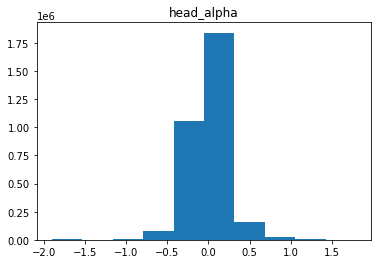

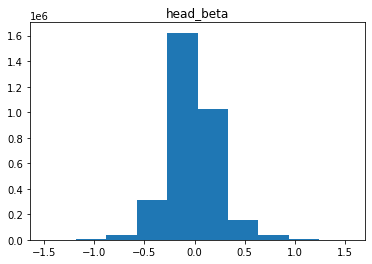

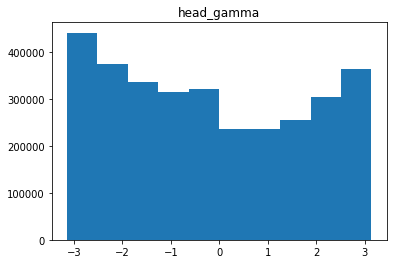

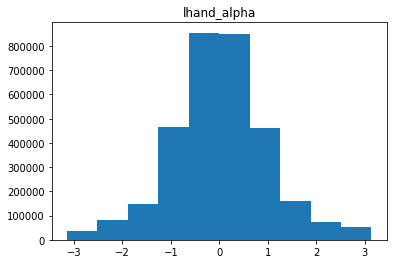

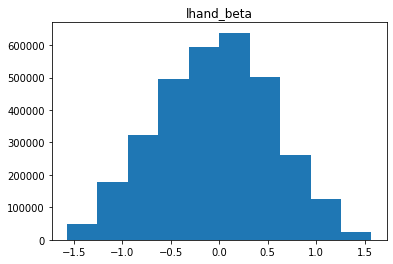

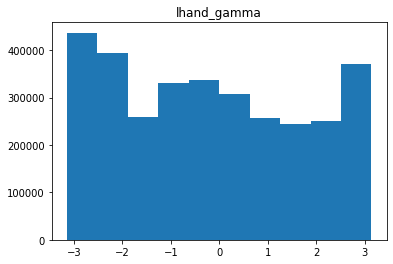

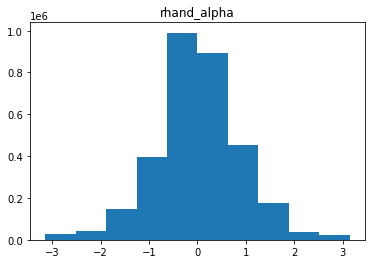

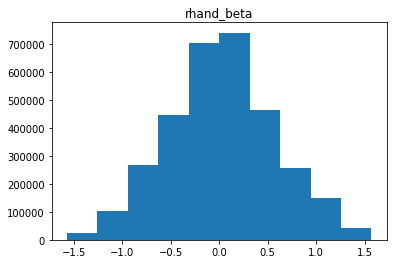

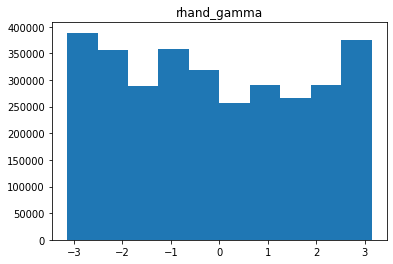

In [8]:
import matplotlib.pyplot as plt

for angle in euler_angles:
    plt.hist(all_weeks_train[angle])
    plt.title(angle)
    plt.show()

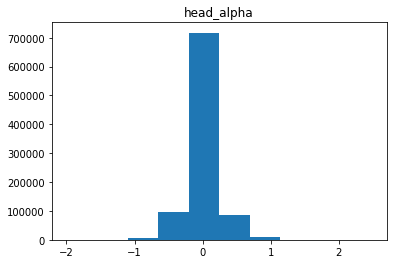

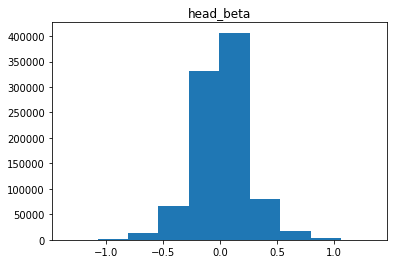

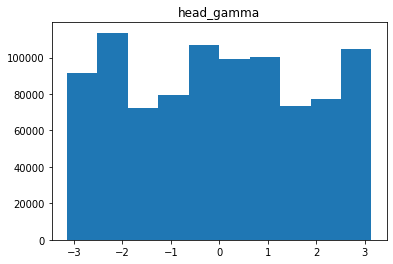

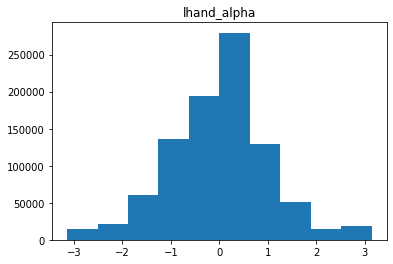

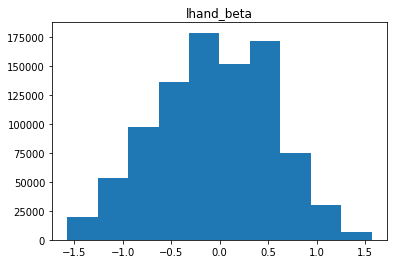

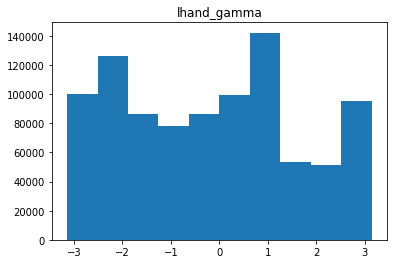

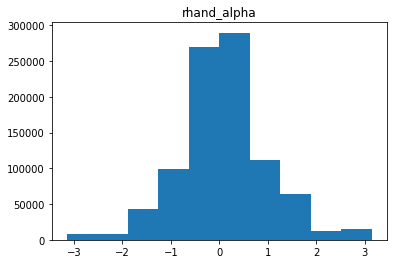

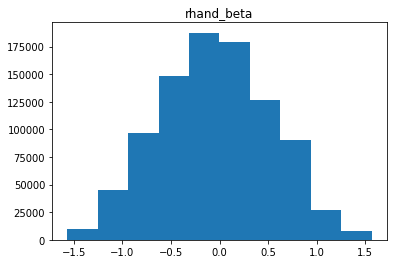

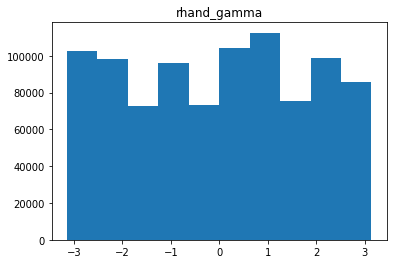

In [9]:
for angle in euler_angles:
    plt.hist(all_weeks_test[angle])
    plt.title(angle)
    plt.show()

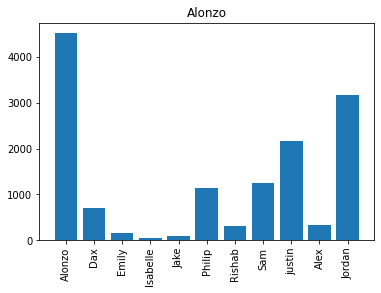

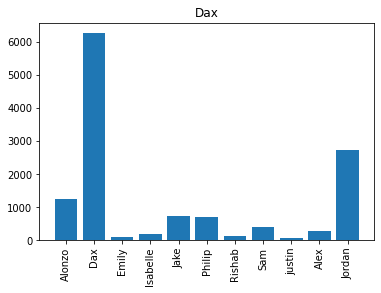

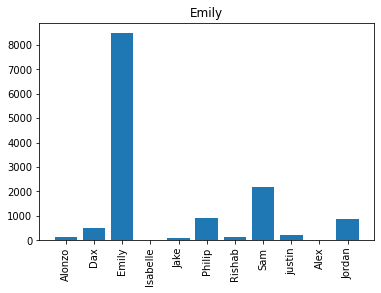

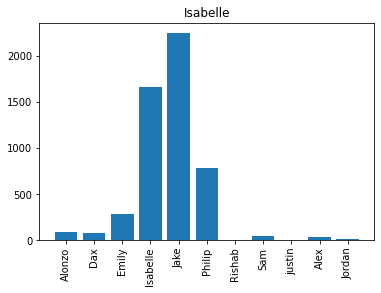

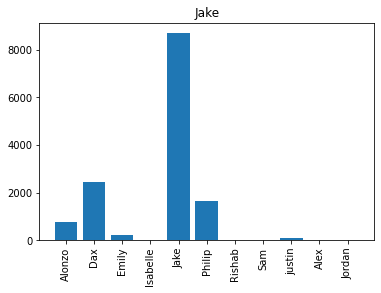

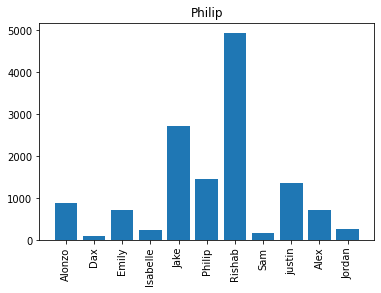

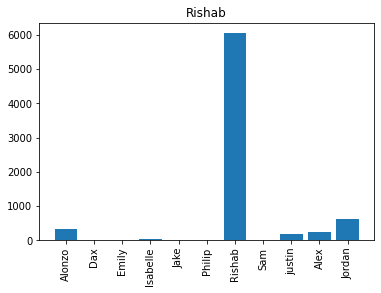

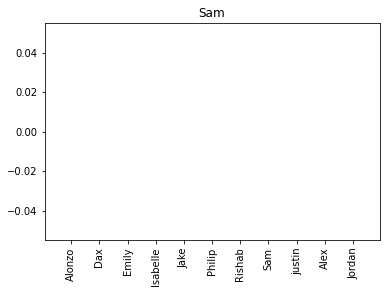

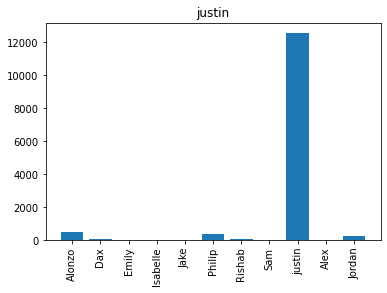

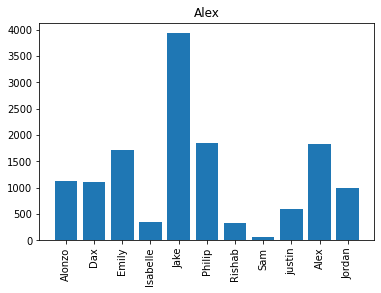

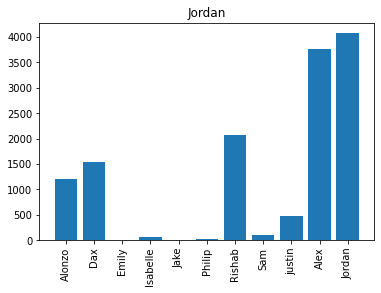

In [10]:
students = ['Alonzo', 'Dax', 'Emily', 'Isabelle', 'Jake', 'Philip', 'Rishab', 'Sam', 'justin', 'Alex', 'Jordan']
labels = [[0 for _ in range(11)] for _ in range(11)]

for i in range(len(y_test)):
    labels[y_test[i]][y_pred[i]] += 1

for i in range(11):
    plt.bar(students, labels[i])
    plt.xticks(rotation=90)
    plt.title(students[i])
    plt.show()